<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/ParametrizANI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI - Dihedral Parametrization in the Cloud with TorchANI**

We have found ourselves several times in a situation where we have to parametrize compounds for running Molecular Dynamics Simulations.
This is a Jupyter notebook to set up a protocol for parametrization of small molecules dihedrals for GAFF and OpenFF force fields using TorchANI as a reference, a PyTorch-based program for training/inference of ANI (ANAKIN-ME) deep learning models to obtain potential energy surfaces and other physical properties of molecular systems.  TorchANI is open-source and freely available on GitHub: https://github.com/aiqm/torchani. 

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to parametrize compounds in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple parametrization pipeline illustrating each step of a protocol.

--- 
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine. 

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization and for the genetic algorithm script.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.


- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI

# **Overview:**

**1.** Create the conformers for each dihedral angle.

**2.** Calculate reference curve with TorchANI.

**3.** Run OpenMM minimization with values ELE+VdW (without dihedral potential contribution).

**4.** Use a genetic algorithm to optimize dihedral values with respect to TorchANI reference.

**5.** Run OpenMM minimization with new dihedral parameters.

**6.** Check if the dihedral angle has the same profile as in TorchANI.

**7.** Create your topology and download the files.

# **Setting the environment for the calculation**

Firstly, we need to install all necessary libraries and packages for our protocol. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    RDKit (https://www.rdkit.org/)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    TorchANI (https://aiqm.github.io/torchani/)

In [1]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel, don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture
!pip -q install py3Dmol
!mamba install pytorch torchvision -c pytorch
!pip install torchani
!pip install ase
!mamba install openmmforcefields -c conda-forge -y
!mamba install -c conda-forge openbabel -y

In [2]:
%%capture
%%bash

#@title **Install dependencies for Genetic Algorithm**
#@markdown It will be fast, I promise. :-P
# install dependencies
mamba create -n genetic python=2.7 --yes
source activate genetic
pip install Pyevolve
pip install numpy

In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec 15 04:49:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Smiles: O=C(OCCO)c1ccc(C(=O)OCCO)cc1


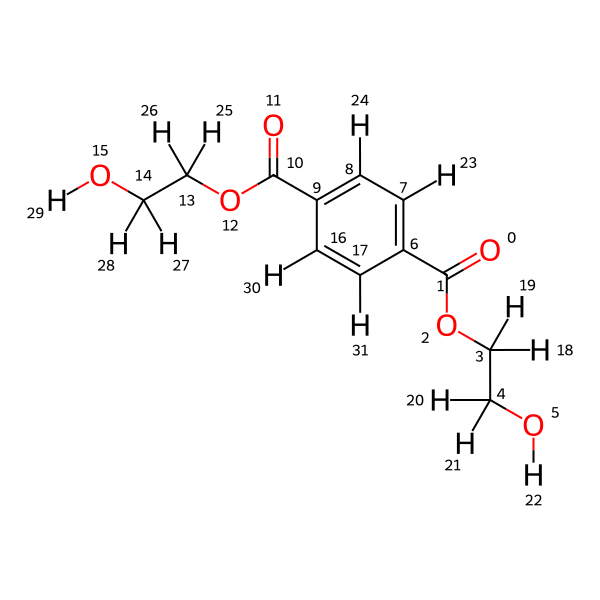

In [3]:
#@title **Please, provide the necessary information for the molecule**: 

#@markdown Type the smiles or filename (PDB and MOL formats) of your molecule. **Ex: C=CC(=O)OC, molecule.pdb or molecule.mol** 

#@markdown Just remind you that if you want to use pdb or mol file, you should first upload the file here in Colab.

#@markdown If you don't know the exactly smiles, please, check at https://pubchem.ncbi.nlm.nih.gov/
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from openbabel import pybel

import os

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

import py3Dmol


Type = "smiles" #@param ["smiles", "pdb", "mol"]

smiles_or_filename = 'O=C(OCCO)c1ccc(C(=O)OCCO)cc1' #@param {type:"string"}
workDir = "/content/"

if Type == "smiles":
  Smiles = smiles_or_filename 
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
elif Type == "pdb":
  mol= [m for m in pybel.readfile(filename=smiles_or_filename, format='pdb')][0]
  out=pybel.Outputfile(filename='mol.mol',format='mol',overwrite=True)
  out.write(mol)
  out.close()
  mol = Chem.MolFromMolFile('mol.mol')
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)
else:
  mol = Chem.MolFromMolFile(smiles_or_filename)
  Smiles = Chem.MolToSmiles(mol)
  smiles_fig = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(smiles_fig)

d2d = rdMolDraw2D.MolDraw2DSVG(600, 600)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(hmol)
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
with open('smiles.svg', 'w') as f:
    f.write(svg)
print("Smiles: " + str(Smiles))
SVG(svg)

In [4]:
#@title ### **Set your dihedral angle (Geometry Optimization with MMFF94 or TorchANI)**
#@markdown Type the number of atoms for your dihedral angle.
#@markdown The dihedral angle we will parametrize will be defined by these atoms.
from termcolor import colored

atom1 = '8' #@param {type:"string"}
atom2 = '9' #@param {type:"string"}
atom3 = '10' #@param {type:"string"}
atom4 = '11' #@param {type:"string"}

#@markdown Select step size in degrees for the dihedral angle rotation:
degrees_steps = "10" #@param ["5","10", "15", "20", "30", "45", "60"]
with open('degrees.dat', 'w') as f:
  f.write(degrees_steps)

optimization = "MMFF94" #@param ["ANI", "MMFF94"]

if optimization == "MMFF94":
  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)
else:
  from typing import List
  from ase import Atoms
  from ase.lattice.cubic import Diamond
  from ase.md.langevin import Langevin
  from ase.optimize import BFGS
  from ase import io
  from ase.io import read, write
  from ase import units
  from ase.constraints import ExternalForce, FixInternals
  import torch
  import torchani
  import pandas as pd
  import numpy as np
  from torchani.units import HARTREE_TO_KCALMOL
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")


  def mol2arr(mols, device=device):
      coordinates = []
      spices = []
      for mol in mols:
          pos = mol.GetConformer().GetPositions().tolist()
          atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
          coordinates.append(pos)
          spices.append(atomnums)
      coordinates = torch.tensor(coordinates, requires_grad=True, device=device)
      species = torch.tensor(spices, device=device)
      return coordinates, species

  mol = Chem.MolFromSmiles(Smiles)
  hmol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(hmol)
  mp = AllChem.MMFFGetMoleculeProperties(hmol)
  ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
  AllChem.OptimizeMolecule(ff, maxIters=1000)
  ff.Minimize()
  charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Chem.GetFormalCharge(hmol)
  print("Charge = " + str(charge))
  if not charge == 0:
    print(colored("ANI cannot do charged system yet, stay tuned!", 'red'))
    exit()
  else:
    pass
  AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start.mol")))
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, f"start.mol")), removeHs=False)
  mol = io.read(os.path.join(workDir, f"start.mol"))
  coordinates, species = mol2arr([mol_deg], device)
  tensor1 = coordinates.detach().numpy()
  atoms = Atoms(mol, positions=tensor1[0])
  atoms.center(vacuum=3.0)
  atoms.set_calculator(calculator)
  print("Begin minimizing ")
  opt = BFGS(atoms)
  opt.run(fmax=0.0001)
  write((os.path.join(workDir, f"start_min.xyz")), format="xyz", images=atoms)

  atomic_symbols = []
  xyz_coordinates = []

  with open((os.path.join(workDir, f"start_min.xyz")), "r") as file:
    for line_number,line in enumerate(file):
      if line_number == 0:
        num_atoms = int(line)
      elif line_number == 1:
        comment = line # might have useful information
      else:
        atomic_symbol, x, y, z = line.split()
        atomic_symbols.append(atomic_symbol)
        xyz_coordinates.append([float(x),float(y),float(z)])

  from rdkit.Geometry import Point3D
  conf = mol_deg.GetConformer()

  for i in range(mol_deg.GetNumAtoms()):
    x,y,z = xyz_coordinates[i]
    conf.SetAtomPosition(i,Point3D(x,y,z))
  AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, f"start_min.mol")))


  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

Charge = 0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
#@title ### **Create the conformers based on your dihedral angle**
#@markdown Run this cell to create the conformers based on your selections from previous cell. To do so, we will rotate the dihedral from -180 to 180 degrees (with a step size chosen in the previous cell).

#@markdown **Important**: The output will show just a few conformers, not all of them. If you check the **mol_files** folder, all of your conformers will be there.


#Create the conformers and save in the folder
import glob
import copy
import numpy as np
from IPython.display import display

if os.path.exists(os.path.join(workDir, "mol_files")):
  for f in glob.glob(os.path.join(workDir, "mol_files/*.mol")):
    os.remove(f)
else:
  os.mkdir(os.path.join(workDir, "mol_files"))

confs = []
filenames = []


if optimization == "ANI":
  hmol = AllChem.MolFromMolFile ((os.path.join(workDir, f"start_min.mol")), removeHs=False)
else:
  pass

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    rdMolTransforms.SetDihedralDeg(hmol.GetConformer(0), int(atom1), int(atom2), int(atom3), int(atom4), deg)
    mp = AllChem.MMFFGetMoleculeProperties(hmol)
    ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
    ff.MMFFAddTorsionConstraint(int(atom1), int(atom2), int(atom3), int(atom4), False, deg, deg, 1000.0,)
    # for a in hmol.GetAtoms():
    #     if (a.GetAtomicNum() > 1):
    #         ff.MMFFAddPositionConstraint(a.GetIdx(), 0.0, 1.e4)
    AllChem.OptimizeMolecule(ff, maxIters=200)
    ff.Minimize(maxIts=1000)
    AllChem.MolToMolFile(hmol, (os.path.join(workDir, "mol_files/" + str(deg) + ".mol")))
    if deg % 90 == 0:
        print(deg)
        display(IPythonConsole.drawMol3D(hmol))

-180


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

-90


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

90


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

180


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

In [8]:
#@title **Calculate reference energy profile using TorchANI**: 

#@markdown Minimization and energy calculation of each conformer, using TorchANI as the optimizing engine.
#@markdown TorchANI will be used to obtain the energy profile of the dihedral angle that will act as a reference.

#@markdown ANI is a general-purpose neural network-based atomistic potential for organic molecules. Four ANI models have been published, the ANI-1, ANI-1x, ANI-1ccx, and ANI-2x potentials. The ANI-1 model was developed by random sampling conformational space of 57k organic molecules with up to eight heavy atoms, C, N, and O, plus H atoms to have proper chemistry, then running DFT calculations to obtain potential energies for training. ANI-1x was trained to a data set of molecular conformations sampled through an active learning scheme. Active learning is where the model itself is iteratively used to decide what new data should be included in the next iteration. ANI-1ccx was trained to the ANI-1x data set, then retrained to a 10% smaller data set of accurate coupled cluster calculations, resulting in a potential that outperformed DFT in test cases. ANI-2x was trained by adding many millions of data points to the ANI-1x data set, at the same level of theory, but including elements S, F, and Cl. We included the **ANI-1x**, **ANI-1ccx**, and **ANI-2x** models in our notebook. 

#@markdown TorchANI will calculate a reliability index, which here is called **RHO**. We set a threshold of 0.6 kcal/mol such that if RHO < 0.6 everything is fine, if RHO > 0.6 be careful and if RHO > 1, the values cannot be used for the fitting. The ouput will show a flag in the cases where we have an issue.

#@markdown If you want to know more about **TorchANI**, please, check at https://aiqm.github.io/torchani/

#@markdown Please, select your ANI model:
model_name = "ANI-2x" #@param ["ANI-1x", "ANI-1ccx", "ANI-2x"]
optimization = "Yes" #@param ["Yes", "No"]

#@markdown Convergence threshold for geometry optimization:

opt_tol = 0.005 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}

from typing import List
from ase import Atoms
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from ase import io
from ase.io import read, write
from ase import units
from ase.constraints import ExternalForce, FixInternals
import torch
import torchani
import pandas as pd
import numpy as np
from torchani.units import HARTREE_TO_KCALMOL
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

if model_name == "ANI-2x":
  model = torchani.models.ANI2x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI2x().ase()
  print("Model = ANI2x")
elif model_name == "ANI-1ccx":
  model = torchani.models.ANI1ccx(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1ccx().ase()
  print("Model = ANI1ccx")
elif model_name == "ANI-1x":
  model = torchani.models.ANI1x(periodic_table_index=True).to(device)
  calculator = torchani.models.ANI1x().ase()
  print("Model = ANI1x")
else:
  pass

def mol2arr(mols, device=device):
    coordinates = []
    spices = []
    for mol in mols:
        pos = mol.GetConformer().GetPositions().tolist()
        atomnums = [a.GetAtomicNum() for a in mol.GetAtoms()]
        coordinates.append(pos)
        spices.append(atomnums)
    coordinates = torch.tensor(coordinates,
                               requires_grad=True,
                               device=device)
    species = torch.tensor(spices, device=device)
    return coordinates, species
if optimization == "Yes":
  for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
    mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files/" + str(deg) + ".mol")), removeHs=False)
    mol = io.read(os.path.join(workDir, "mol_files/" + str(deg) + ".mol"))
    coordinates, species = mol2arr([mol_deg], device)
    tensor1 = coordinates.detach().numpy()
    atoms = Atoms(mol, positions=tensor1[0])
    atoms.center(vacuum=3.0)
    dihedral_indices1 = [int(atom1), int(atom2), int(atom3), int(atom4)]
    dihedral1 = [atoms.get_dihedral(*dihedral_indices1), dihedral_indices1]
    c = FixInternals(dihedrals_deg=[dihedral1])
    atoms.set_constraint(c)
    atoms.set_calculator(calculator)
    print("Begin minimizing " + str(deg) + ".mol" )
    opt = BFGS(atoms)
    opt.run(fmax=opt_tol)
    write((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), format="xyz", images=atoms)

    atomic_symbols = []
    xyz_coordinates = []

    with open((os.path.join(workDir, "mol_files/" + str(deg) + "_min.xyz")), "r") as file:
      for line_number,line in enumerate(file):
          if line_number == 0:
              num_atoms = int(line)
          elif line_number == 1:
              comment = line # might have useful information
          else:
              atomic_symbol, x, y, z = line.split()
              atomic_symbols.append(atomic_symbol)
              xyz_coordinates.append([float(x),float(y),float(z)])

    from rdkit.Geometry import Point3D
    conf = mol_deg.GetConformer()

    for i in range(mol_deg.GetNumAtoms()):
      x,y,z = xyz_coordinates[i]
      conf.SetAtomPosition(i,Point3D(x,y,z))
    AllChem.MolToMolFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.mol")))
    AllChem.MolToPDBFile(mol_deg, (os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb")))
  mol_energy = "_min.mol"
else:
  mol_energy = ".mol"

#TorchANI Energies
energy_list = []
dihe_degree = []
qbc_list = []

for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  mol_deg = AllChem.MolFromMolFile ((os.path.join(workDir, "mol_files/" + str(deg) +  str(mol_energy))), removeHs=False)
  coordinates, species = mol2arr([mol_deg], device)
  energy = model((species, coordinates)).energies
  energies_list = []
  for i in range(0,8,1):
    modeli = model[i]
    energyi = modeli((species, coordinates)).energies
    energies_list.append(energyi.item())
  qbc_factors = np.std(energies_list)
  num_atoms = (species >= 0).sum(dim=1)
  qbc_factors = (qbc_factors / num_atoms.sqrt()) * HARTREE_TO_KCALMOL
  qbc_list.append(qbc_factors.item())  
  # derivative = torch.autograd.grad(energy.sum(), coordinates)[0]
  # force = -derivative
  energy_list.append(energy.item())
  dihe_degree.append(deg)

#Calculates the relative energy from ANI energies
ani_energies = (np.array(energy_list) - min(energy_list)) * HARTREE_TO_KCALMOL

print("Degrees    Energy              RHO factor")
with open('ani.dat', 'w') as f:
    for deg, item, item2 in zip(dihe_degree, ani_energies, qbc_list):
      degree_str = str("{:.3f}".format(deg))
      energy_str = str("{:.3f}".format(item))
      rho = str("{:.3f}".format(item2))
      string = degree_str.rjust(8, " ") + energy_str.rjust(8, " ") + " kcal/mol   |  " + rho.ljust(8, " ") + " kcal/mol"
      if item2 >= 0.6 and item2 < 1:    
          print(string + str(" WARNING:Check the plot!"))
      elif item2 >= 1:
          print(string + str(" WARNING:Do not use this value for the fitting!"))
      else:
          print(string)
      f.write("%s\n" % item)

Model = ANI2x
Begin minimizing -180.mol
      Step     Time          Energy         fmax
BFGS:    0 08:25:25   -24947.957104        1.2502
BFGS:    1 08:25:25   -24948.020651        1.1980
BFGS:    2 08:25:25   -24948.055986        0.4103


/usr/local/lib/python3.8/site-packages/torchani/ase.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/utils/tensor_new.cpp:230.)
  cell = torch.tensor(self.atoms.get_cell(complete=True),


Streaming output truncated to the last 5000 lines.
BFGS:   49 08:25:40   -24948.103696        0.0183
BFGS:   50 08:25:40   -24948.103764        0.0182
BFGS:   51 08:25:40   -24948.103852        0.0199
BFGS:   52 08:25:40   -24948.103971        0.0241
BFGS:   53 08:25:40   -24948.104089        0.0180
BFGS:   54 08:25:40   -24948.104193        0.0342
BFGS:   55 08:25:40   -24948.104282        0.0171
BFGS:   56 08:25:41   -24948.104383        0.0158
BFGS:   57 08:25:41   -24948.104467        0.0170
BFGS:   58 08:25:41   -24948.104530        0.0153
BFGS:   59 08:25:41   -24948.104583        0.0145
BFGS:   60 08:25:41   -24948.104642        0.0159
BFGS:   61 08:25:41   -24948.104698        0.0147
BFGS:   62 08:25:41   -24948.104758        0.0172
BFGS:   63 08:25:41   -24948.104819        0.0177
BFGS:   64 08:25:41   -24948.104891        0.0177
BFGS:   65 08:25:41   -24948.104974        0.0169
BFGS:   66 08:25:41   -24948.105047        0.0127
BFGS:   67 08:25:41   -24948.105104        0.0123

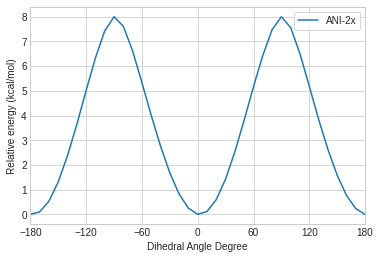

In [9]:
#@title **Check the reference profile calculated with TorchANI**: 

#@markdown y-axis with energy in kcal/mol and x-axis with dihedral angle degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(dihe_degree, ani_energies, linewidth = 1.5, label = model_name)
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("ani.png", dpi=600, bbox_inches='tight')

In [20]:
#@title **OpenMM minimization with dihedral potential energy set to 0:**
#@markdown Set the parameters to **0** if you want to perform a minimization of the conformers only taking into account Van der Waals and electrostatic contributions, without dihedral energies (only in the dihedral we are parametrizing). **Select this option if you want to parametrize a new dihedral potential.**

#@markdown Set the parameters to **Default** if you want to perform minimization of the conformers with the dihedral energies from the chosen force field. With this option you can check how good the force field parameters are to describe the chosen dihedral angle.


#@markdown **Parameters to generate the molecule topology:**

Force_field = "gaff-2.11" #@param ['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11', 'smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1', 'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4', 'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1', 'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']
Dihedral_potential_energy = "0" #@param ['0', 'Default']

#@markdown Force constant to restrain the dihedral angle:

Force_constant = 1000 #@param {type:"slider", min:100, max:2000, step:100}


#@markdown Convergence threshold for minimization energy:

opt_tol = 0.001 #@param {type:"slider", min:0.001, max:0.1, step:0.001}

import warnings
warnings.filterwarnings("ignore")
from mdtraj.geometry import dihedral
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
# Imports from the toolkit
import openff.toolkit
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmmforcefields.generators import GAFFTemplateGenerator

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch


workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy.txt")):
  for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
    os.remove(f)
  os.remove(os.path.join(workDir2,"potential_energy.txt"))
else:
  if os.path.exists(os.path.join(workDir2, "pdb_min")):
    for f in glob.glob(os.path.join(workDir2, "pdb_min/*.pdb")):
      os.remove(f)
    os.rmdir(os.path.join(workDir2, "pdb_min"))
    os.mkdir(os.path.join(workDir2, "pdb_min"))
  else:
    os.mkdir(os.path.join(workDir2, "pdb_min"))


# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

small_ff_options = ['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11', 'smirnoff99Frosst-1.1.0', 'smirnoff99Frosst-1.0.0', 'smirnoff99Frosst-1.0.9', 'smirnoff99Frosst-1.0.1', 
            'smirnoff99Frosst-1.0.6', 'smirnoff99Frosst-1.0.5', 'smirnoff99Frosst-1.0.7', 'smirnoff99Frosst-1.0.8', 'smirnoff99Frosst-1.0.2', 'smirnoff99Frosst-1.0.4', 
            'smirnoff99Frosst-1.0.3', 'openff-1.0.0-RC1', 'openff-1.0.1', 'openff-1.3.1-alpha.1', 'openff-1.0.0', 'openff-1.2.0', 'openff-2.0.0-rc.2', 'openff-2.0.0-rc.1', 
            'openff-2.0.0', 'openff-1.1.0', 'openff-1.3.1', 'openff-1.1.1', 'openff-1.0.0-RC2', 'openff-1.3.0', 'openff-1.2.1']

type_generator_options = ('GAFF', 'GAFF', 'GAFF', 'GAFF', 'GAFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF',
                          'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF', 'SMIRNOFF')

small_ff_include = ["'gaff-1.4'", "'gaff-1.8'", "'gaff-1.81'", "'gaff-2.1'", "'gaff-2.11'", "'smirnoff99Frosst-1.1.0'", "'smirnoff99Frosst-1.0.0'", "'smirnoff99Frosst-1.0.9'", "'smirnoff99Frosst-1.0.1'", 
            "'smirnoff99Frosst-1.0.6'", "'smirnoff99Frosst-1.0.5'", "'smirnoff99Frosst-1.0.7'", "'smirnoff99Frosst-1.0.8'", "'smirnoff99Frosst-1.0.2'", "'smirnoff99Frosst-1.0.4'", 
            "'smirnoff99Frosst-1.0.3'", "'openff-1.0.0-RC1'", "'openff-1.0.1'", "'openff-1.3.1-alpha.1'", "'openff-1.0.0'", "'openff-1.2.0'", "'openff-2.0.0-rc.2'", "'openff-2.0.0-rc.1'", 
            "'openff-2.0.0'", "'openff-1.1.0'", "'openff-1.3.1'", "'openff-1.1.1'", "'openff-1.0.0-RC2'", "'openff-1.3.0'", "'openff-1.2.1'"]


small_ff_id = small_ff_options.index(Force_field)
type_generator = type_generator_options[small_ff_id]
small_ff = small_ff_include[small_ff_id]

# Teach OpenMM about the ligand molecule and force field
ligand_generator = type_generator + "TemplateGenerator(forcefield=" + small_ff + ", molecules=[molecule])"
type_generator_options = eval(ligand_generator)


# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))
  system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)

  for i, f in enumerate(system.getForces()):
    f.setForceGroup(i)
   

  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  if Dihedral_potential_energy == "0":
    dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
    for i in range(dih.getNumTorsions()):
      particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
      if particle2 == int(atom2) and particle3 == int(atom3):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      elif particle2 == int(atom3) and particle3 == int(atom2):
        # print(dih.getTorsionParameters(i))
        dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
        dih.updateParametersInContext(simulation.context)
        # print(dih.getTorsionParameters(i))
      else:
        pass
  else:
    pass
         
  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/mole, maxIterations=int(1000000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())
  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy.txt", "a",))

#Prepare the relative energy from MM 
import pandas as pd
dataset = pd.read_csv('/content/potential_energy.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_diff = (np.array(new) - min(new)) * 0.239006
# print(np.round(energy_diff, 4))

print("Degrees    Energy")
#save a dat file
energy_mm = np.round(energy_diff, 4)
a_file = open("mm.dat", "w")
for deg, row in zip(dihe_degree, energy_mm):
    degree_str = str("{:.3f}".format(deg))
    energy_mm_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_mm_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

Running minimization for step:-180
Running minimization for step:-170
Running minimization for step:-160
Running minimization for step:-150
Running minimization for step:-140
Running minimization for step:-130
Running minimization for step:-120
Running minimization for step:-110
Running minimization for step:-100
Running minimization for step:-90
Running minimization for step:-80
Running minimization for step:-70
Running minimization for step:-60
Running minimization for step:-50
Running minimization for step:-40
Running minimization for step:-30
Running minimization for step:-20
Running minimization for step:-10
Running minimization for step:0
Running minimization for step:10
Running minimization for step:20
Running minimization for step:30
Running minimization for step:40
Running minimization for step:50
Running minimization for step:60
Running minimization for step:70
Running minimization for step:80
Running minimization for step:90
Running minimization for step:100
Running minimiza

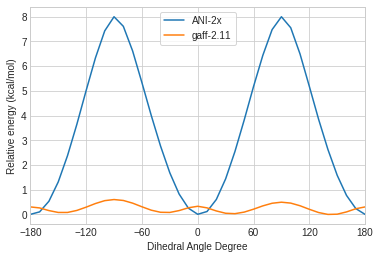

In [21]:
#@title **Check the reference profile calculated with OpenMM**: 

#@markdown y-axis with relative energy in kcal/mol and x-axis with dihedral angle degrees.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(dihe_degree, ani_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("ani_mm.png", dpi=600, bbox_inches='tight')

In [12]:
%%bash
#@title **Use a genetic algorithm to optimize dihedral values with respect to TorchANI**: 

#@markdown In this cell, we will optimize the dihedral values found in OpenMM minimization using a genetic algorithm from python package "pyevolve".

source activate genetic
python
import numpy as npy
import sys
from pyevolve import G1DList
from pyevolve import GSimpleGA
from pyevolve import Selectors
from pyevolve import Mutators
from pyevolve import Initializators
from pyevolve import GAllele
import math

ani_file="ani.dat"
mm_file="mm.dat"
degrees_file="degrees.dat"

ani=map(float,open(ani_file).read().split())
mm=map(float,open(mm_file).read().split())
degrees=open(degrees_file).read()

angles=range(-180,(180+int(degrees)),int(degrees))

###########################################################
##  TWO CURVE FITTING
###########################################################
def calc_fitted_2graphs(PKIDVF1,PN1,PHASE1,PKIDVF2,PN2,PHASE2):
	values=[]
	for i,ANGLE in enumerate(angles):
		EDIHEDRAL1=PKIDVF1*(1+math.cos(math.radians(PN1*ANGLE-PHASE1)))
		EDIHEDRAL2=PKIDVF2*(1+math.cos(math.radians(PN2*ANGLE-PHASE2)))
		values.append(EDIHEDRAL1+EDIHEDRAL2+mm[i])
	values=npy.array(values)
	values=values-min(values)
	err=[]
	for i,value in enumerate(values):
		err.append(value-ani[i])
	err=npy.array(err)
	rmsd=npy.sqrt(npy.sum(err**2)/len(err))
	return rmsd

#function for ranking chromosomes
def eval_func_2graphs(chromosome):
	score=0.0
	rmsd=calc_fitted_2graphs(chromosome[0],chromosome[1],chromosome[2],chromosome[6]*chromosome[3],chromosome[4],chromosome[5])
	if chromosome[1] == chromosome[4] and chromosome[2] == chromosome[5] and chromosome[6] == 1:
		rmsd=rmsd*2
	score=1/rmsd
	return score

#initialize alleles	
setOfAlleles=GAllele.GAlleles()

#first variable
pkidvf=npy.arange(0.1,30.1,0.1)
setOfAlleles.add(GAllele.GAlleleList(pkidvf))
#second variable
pn=npy.arange(1,8.1,1)
setOfAlleles.add(GAllele.GAlleleList(pn))
#third variable
phase=npy.arange(-180,180.1,int(degrees))
setOfAlleles.add(GAllele.GAlleleList(phase))

#repeat assignment of variables for second curve
setOfAlleles.add(GAllele.GAlleleList(pkidvf))
setOfAlleles.add(GAllele.GAlleleList(pn))
setOfAlleles.add(GAllele.GAlleleList(phase))

#binary value for using 1 or 2 functions
func1or2=[0,1]
setOfAlleles.add(GAllele.GAlleleList(func1or2))

#initialize genome with defined alleles
genome = G1DList.G1DList(7)
genome.setParams(allele=setOfAlleles)

#define evaluator function
genome.evaluator.set(eval_func_2graphs)
genome.mutator.set(Mutators.G1DListMutatorAllele)
genome.initializator.set(Initializators.G1DListInitializatorAllele)

ga = GSimpleGA.GSimpleGA(genome)
ga.selector.set(Selectors.GRouletteWheel)
ga.setCrossoverRate(0.85)
ga.setElitism(True)
ga.setGenerations(5000)
ga.evolve(freq_stats=1000)

best=ga.bestIndividual()
############################################################

#only one plot for optimization
print "The optimized values for only 1 function are:"
print "\tPK/IDIVF = \t"+str(best[0])
print "\tPHASE = \t"+str(best[2])
print "\tPN = \t\t"+str(best[1])

print "The optimized values for 2 functions are:"
print "Function 1:"
print "\tPK/IDIVF = \t"+str(best[0])
print "\tPHASE = \t"+str(best[2])
print "\tPN = \t\t"+str(best[1])
print "Function 2:"
print "\tPK/IDIVF = \t"+str(best[3])
print "\tPHASE = \t"+str(best[5])
print "\tPN = \t\t"+str(best[4])

f1=open('new_potentials.txt', 'w+')
f1.write(str(best[0]) + "\n")
f1.write(str(best[2]) + "\n")
f1.write(str(best[1]) + "\n")
f1.write(str(best[3]) + "\n")
f1.write(str(best[5]) + "\n")
f1.write(str(best[4]) + "\n")
f1.close()

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [0.08(0.31)/0.06(0.02)/0.07(0.07)]
Gen. 1000 (20.00%): Max/Min/Avg Fitness(Raw) [0.31(4.38)/0.25(0.03)/0.26(0.26)]
Gen. 2000 (40.00%): Max/Min/Avg Fitness(Raw) [0.36(4.38)/0.30(0.02)/0.30(0.30)]
Gen. 3000 (60.00%): Max/Min/Avg Fitness(Raw) [0.24(4.38)/0.20(0.03)/0.20(0.20)]
Gen. 4000 (80.00%): Max/Min/Avg Fitness(Raw) [0.25(4.38)/0.21(0.03)/0.21(0.21)]
Gen. 5000 (100.00%): Max/Min/Avg Fitness(Raw) [0.13(4.38)/0.11(0.02)/0.11(0.11)]
Total time elapsed: 47.484 seconds.
The optimized values for only 1 function are:
	PK/IDIVF = 	16.900000000000002
	PHASE = 	0.0
	PN = 		2.0
The optimized values for 2 functions are:
Function 1:
	PK/IDIVF = 	16.900000000000002
	PHASE = 	0.0
	PN = 		2.0
Function 2:
	PK/IDIVF = 	20.500000000000004
	PHASE = 	-180.0
	PN = 		2.0


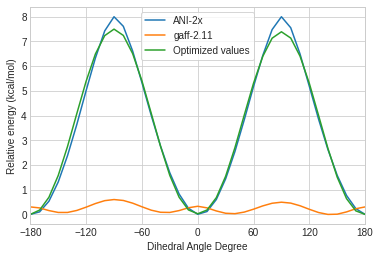

In [13]:
#@title **Check the new profile optimized with genetic algorithm**: 

#@markdown  The values that are printed in the previous cell, are the values that we should add to the force field to have a correct parametrization of the dihedral.

#@markdown  Select how many functions do you want to add to your topology:

dataset = pd.read_csv('/content/new_potentials.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
PK_IDIVF1 = df.iloc[0]
PHASE1 = df.iloc[1]
PN1 = df.iloc[2]

PK_IDIVF2 = df.iloc[3]
PHASE2 = df.iloc[4]
PN2 = df.iloc[5]


functions = "2" #@param ["1", "2"]

if functions == "1":
  dict_params = {0: [PK_IDIVF1, PHASE1, PN1]}
  values=[]
  mm_file="mm.dat"
  mm=list(map(float,open(mm_file).read().split()))
  angles=range(-180,(180+int(degrees_steps)),int(degrees_steps))
  for i,ANGLE in enumerate(angles):
    EDIHEDRAL1=PK_IDIVF1*(1+math.cos(math.radians(PN1*ANGLE-PHASE1)))
    values.append(EDIHEDRAL1+mm[i])
  values=np.array(values)
  values=values-min(values)
  # print(values)
elif functions == "2":
  dict_params = {0: [PK_IDIVF1, PHASE1, PN1], 1: [PK_IDIVF2, PHASE2, PN2]}
  values=[]
  mm_file="mm.dat"
  mm=list(map(float,open(mm_file).read().split()))
  angles=range(-180,(180+int(degrees_steps)),int(degrees_steps))
  for i,ANGLE in enumerate(angles):
    EDIHEDRAL1=PK_IDIVF1*(1+math.cos(math.radians(PN1*ANGLE-PHASE1)))
    EDIHEDRAL2=PK_IDIVF2*(1+math.cos(math.radians(PN2*ANGLE-PHASE2)))
    values.append(EDIHEDRAL1+EDIHEDRAL2+mm[i])
  values=np.array(values)
  values=values-min(values)
  # print(values)
else:
  pass

#Plot ANI, MM and the new dihedral potential 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

plt.plot(dihe_degree, ani_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("ani_mm_ga.png", dpi=600, bbox_inches='tight')

In [14]:
#@title **OpenMM minimization with new dihedral potential optimized with genetic algorithm:**
#@markdown We are performing a minimization of the structure with the new dihedral energies parametrized.

#@markdown **Important:** Force field, force constant and convergence threshold parameters will be the same from previous OpenMM minimization.

from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
from simtk.openmm.app import PDBFile

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt
import xml.etree.ElementTree as ET
xml = openmm.XmlSerializer.serialize(system)
root = ET.fromstring(xml)

from sys import stdout, exit, stderr
import os, math, fnmatch

workDir2 = "/content/"

if os.path.exists(os.path.join(workDir2, "potential_energy_new.txt")):
  os.remove(os.path.join(workDir2,"potential_energy_new.txt"))
else:
  pass

# Create an OpenFF Molecule object for benzene from sdf
from openff.toolkit.topology import Molecule
molecule = Molecule.from_smiles(Smiles)
# molecule = Molecule.from_file("/content/mol_files/0_min.mol")

# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from simtk.openmm.app import ForceField
forcefield = ForceField('amber99sb.xml')

# Register the  template generator
forcefield.registerTemplateGenerator(type_generator_options.generator)

potential_energy = []
dihe_degree = []
for deg in range(-180, (180+int(degrees_steps)), int(degrees_steps)):
  pdbfile = PDBFile(os.path.join(workDir, "mol_files/" + str(deg) + "_min.pdb"))
  system = forcefield.createSystem(pdbfile.topology, nonbondedCutoff=1*nanometer, constraints=HBonds)


  energy_expression = "k*(1-cos(periodicity*theta-theta0))"
  custom_torsion_force = CustomTorsionForce(energy_expression)
  custom_torsion_force.addGlobalParameter("k", int(Force_constant))
  custom_torsion_force.addGlobalParameter("periodicity", 1)
  custom_torsion_force.addGlobalParameter("theta0", math.radians(deg))
  custom_torsion_force.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4))
  system.addForce(custom_torsion_force)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  count = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    count += 1

  integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
  simulation = Simulation(pdbfile.topology, system, integrator)
  simulation.context.setPositions(pdbfile.positions)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
    if particle2 == int(atom2) and particle3 == int(atom3):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)
    elif particle2 == int(atom3) and particle3 == int(atom2):
      dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 1, 0, 0)
      dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  a = (dih.getNumTorsions() - 1) - count
  b = 0
  for k,v in dict_params.items():
    PK_IDIVF, PHASE, PN = v
    b += 1
    dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
    dih.updateParametersInContext(simulation.context)

  dih = [f for f in system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
  for i in range(dih.getNumTorsions()):
    particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
    # if particle2 == int(atom2) and particle3 == int(atom3):
    #   print(dih.getTorsionParameters(i))
  
  simulation.minimizeEnergy(tolerance=float(opt_tol)*kilojoule/mole, maxIterations=int(10000))
  minpositions = simulation.context.getState(getPositions=True).getPositions()
  app.PDBFile.writeFile(pdbfile.topology, minpositions, open(os.path.join(workDir2, "pdb_min/" + str(deg) + '_min_new.pdb'), 'w'))

  energy_kcal =  (simulation.context.getState(getEnergy=True).getPotentialEnergy())
  potential_energy.append(energy_kcal)
  dihe_degree.append(deg)
  for i, f in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={i})
    # print(f.getName(), state.getPotentialEnergy())

  # print(str(deg) + " =", str(energy_kcal))
  print("Running minimization for step:" + str(deg))
  print(str(energy_kcal), file=open("potential_energy_new.txt", "a",))

#Prepare the relative energy from MM with new dihedral potential
import pandas as pd
dataset = pd.read_csv('/content/potential_energy_new.txt', delimiter = " ", header=None)
df = pd.DataFrame(dataset)
df = df[df.columns[:1]]
new = df.to_numpy()
energy_new = (np.array(new) - min(new)) * 0.239006

print("Degrees    Energy")
energy_mm_new = np.round(energy_new, 4)
a_file = open("mm_new.dat", "w")
for deg, row in zip(dihe_degree, energy_new):
    degree_str = str("{:.3f}".format(deg))
    energy_new_str = str("{:.3f}".format(row[0]))
    string = degree_str.rjust(8, " ") + energy_new_str.rjust(8, " ") + " kcal/mol"
    print(string)
    np.savetxt(a_file, row, fmt='%.6f')
a_file.close()

Running minimization for step:-180
Running minimization for step:-170
Running minimization for step:-160
Running minimization for step:-150
Running minimization for step:-140
Running minimization for step:-130
Running minimization for step:-120
Running minimization for step:-110
Running minimization for step:-100
Running minimization for step:-90
Running minimization for step:-80
Running minimization for step:-70
Running minimization for step:-60
Running minimization for step:-50
Running minimization for step:-40
Running minimization for step:-30
Running minimization for step:-20
Running minimization for step:-10
Running minimization for step:0
Running minimization for step:10
Running minimization for step:20
Running minimization for step:30
Running minimization for step:40
Running minimization for step:50
Running minimization for step:60
Running minimization for step:70
Running minimization for step:80
Running minimization for step:90
Running minimization for step:100
Running minimiza

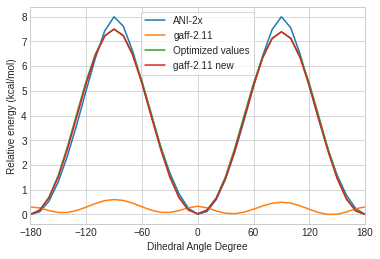

In [15]:
#@title **Check the profile calculated with new dihedral parameters on OpenMM**: 

#@markdown y-axis with relative energy in kcal/mol and x-axis with dihedral angle degrees.

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


plt.plot(dihe_degree, ani_energies, linewidth = 1.5, label = model_name)
plt.plot(dihe_degree, energy_diff, linewidth = 1.5, label = Force_field)
plt.plot(dihe_degree, values, linewidth = 1.5, label = "Optimized values")
plt.plot(dihe_degree, energy_new, linewidth = 1.5, label = str(Force_field) + " new")
plt.xticks(np.arange(min(dihe_degree), max(dihe_degree)+1, 60.0))
plt.xlim([-180, 180])
plt.legend(frameon=True)
plt.xlabel('Dihedral Angle Degree')
plt.ylabel('Relative energy (kcal/mol)')
plt.savefig("ani_mm_ga_new.png", dpi=600, bbox_inches='tight')

In [16]:
#@title **Building the new topology**: 

#@markdown Select the program of your choice:

program = "All" #@param ["All", "AMBER", "GROMACS", "OpenMM"]

from openff.toolkit.topology import Molecule, Topology
import parmed

topology = pdbfile.topology
# Create the Open Forcefield Topology.

omm_system = forcefield.createSystem(pdbfile.topology)
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# Convert OpenMM System to a ParmEd structure.

dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
count = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  dih.addTorsion(int(atom1), int(atom2), int(atom3), int(atom4), PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  count = count + 1
  
simulation = Simulation(pdbfile.topology, omm_system, integrator)
simulation.context.setPositions(pdbfile.positions)
  
dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
for i in range(dih.getNumTorsions()):
  particle1, particle2, particle3, particle4, periodicity, phase, k = dih.getTorsionParameters(i)
  if particle2 == int(atom2) and particle3 == int(atom3):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 0, 0, 0)
    dih.updateParametersInContext(simulation.context)
  elif particle2 == int(atom3) and particle3 == int(atom2):
    dih.setTorsionParameters(i, particle1, particle2, particle3, particle4, 0, 0, 0)
    dih.updateParametersInContext(simulation.context)
  
dih = [f for f in omm_system.getForces() if isinstance(f, PeriodicTorsionForce)][0]
a = (dih.getNumTorsions() - 1) - count
b = 0
for k,v in dict_params.items():
  PK_IDIVF, PHASE, PN = v
  b = b + 1
  dih.setTorsionParameters(a+b, particle1, particle2, particle3, particle4, PN, math.radians(PHASE)*radians, PK_IDIVF*kilojoules_per_mole*4.184)
  dih.updateParametersInContext(simulation.context)

parmed_structure = parmed.openmm.load_topology(pdbfile.topology, omm_system, pdbfile.positions)

if program == "AMBER":
  
  parmed_structure.save('system_amber.prmtop', overwrite=True)
  parmed_structure.save('system_amber.inpcrd', overwrite=True)
  parmed_structure.save('system_amber.pdb', overwrite=True)
  parmed_structure.save('system_amber.mol2', overwrite=True)

  amber_top = os.path.exists('system_amber.prmtop')
  amber_crd = os.path.exists('system_amber.inpcrd')
  amber_pdb = os.path.exists('system_amber.pdb') 
  if amber_top == True and amber_crd == True and amber_pdb == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

elif program == "GROMACS":
  
  parmed_structure.save('system_gromacs.top', overwrite=True)
  parmed_structure.save('system_gromacs.gro', overwrite=True)
  parmed_structure.save('system_gromacs.pdb', overwrite=True)
  gromacs_top = os.path.exists('system_gromacs.top')
  gromacs_gro = os.path.exists('system_gromacs.gro')
  gromacs_pdb = os.path.exists('system_gromacs.pdb')
  if gromacs_top == True and gromacs_gro == True and gromacs_pdb == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

elif program == "OpenMM":

  parmed_structure.save('system_openMM.pdb', overwrite=True)
  with open('system_openMM.xml', 'w') as output:
    output.write(XmlSerializer.serialize(omm_system))
  openmm_pdb = os.path.exists('system_openMM.pdb')
  openmm_xml = os.path.exists('system_openMM.xml') 
  if openmm_pdb == True and openmm_xml == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:

  parmed_structure.save('system_amber.prmtop', overwrite=True)
  parmed_structure.save('system_amber.inpcrd', overwrite=True)
  parmed_structure.save('system_amber.pdb', overwrite=True)
  
  parmed_structure.save('system_gromacs.top', overwrite=True)
  parmed_structure.save('system_gromacs.gro', overwrite=True)
  parmed_structure.save('system_gromacs.pdb', overwrite=True)
  
  parmed_structure.save('system_openMM.pdb', overwrite=True)
  with open('system_openMM.xml', 'w') as output:
    output.write(XmlSerializer.serialize(omm_system))

  amber_top = os.path.exists('system_amber.prmtop')
  amber_crd = os.path.exists('system_amber.inpcrd')
  amber_pdb = os.path.exists('system_amber.pdb')
  gromacs_top = os.path.exists('system_gromacs.top')
  gromacs_gro = os.path.exists('system_gromacs.gro')
  gromacs_pdb = os.path.exists('system_gromacs.pdb')
  openmm_pdb = os.path.exists('system_openMM.pdb')
  openmm_xml = os.path.exists('system_openMM.xml')
  if amber_top == True and amber_crd == True and amber_pdb == True and gromacs_top == True and gromacs_gro == True and gromacs_pdb == True and openmm_pdb == True and openmm_xml == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

Successfully generated topology! :-)


In [17]:
#@title **Download your results**
from google.colab import files

if os.path.exists("dihedral_parameters.zip"):
  os.remove("dihedral_parameters.zip")
else:
  pass

!zip -FSr "dihedral_parameters.zip" "mol_files" "pdb_min" *".gro" *".pdb" *".top" *".prmtop" *".inpcrd" *".png" *."txt" *."dat" *."xml" *."svg"  >/dev/null 2>&1
files.download('dihedral_parameters.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>